In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm as cm
import numpy as np
import re

import spacy
from pymystem3 import Mystem
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn

import string
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# DOwnloads

In [97]:
arr = os.listdir('../input/')
arr_df = pd.DataFrame(arr, columns = ['file_name'])
arr_df

,file_name
0,14773455.jl
1,file_7321705_455951711_124.jl
2,file_11834040_455951711_112.jl
3,w2.jl
4,file_10094987_455951711_145.jl
5,file_7233646_1133395834_1558.jl
6,.DS_Store
7,w3.jl
8,17597852.jl
9,5044562.jl


In [98]:
file_index = 5
path = f'../input/{arr_df["file_name"][file_index]}'

In [99]:
columns = ['comment', 'date_time', 'color','size', 'thumb_up', 'thumb_down', 'prod_eval', 'prod', 'brand']

df = pd.read_json(path).transpose().reset_index().drop('index', axis=1)
df = df.set_axis(columns, axis = 'columns')

df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Носочки соответствуют цене, похоже долго их но...",2021-02-09T10:02:50Z,светло-серый,24,2,0,3,Носки - 2 пары,Носи свое!
1,"Вроде неплохо, тонковато немного. Но! Неужели ...",2021-02-08T15:02:01Z,светло-серый,20,1,0,4,Носки - 2 пары,Носи свое!
2,"Носочки хорошие, когда заказала второй раз вме...",2020-10-14T06:39:20Z,светло-серый,24,1,0,1,Носки - 2 пары,Носи свое!
3,"Носочки вполне достойные. Брали на ножку 14,5 ...",2020-09-01T12:09:16Z,светло-серый,16,1,0,5,Носки - 2 пары,Носи свое!
4,"Незнаю, что за такие новейшие технологии, но н...",2020-08-26T08:46:14Z,светло-серый,16,3,0,2,Носки - 2 пары,Носи свое!


# Функции: Clean_text, Stopwords_del

In [100]:
def delete_non_letters(words):
    new_words = []
    words = words.split()
    
    for word in words:
        new_word = "".join(c if c.isalpha() else " " for c in word )
        
        if new_word != '':
            new_words.append(new_word)
    text = ' '.join(c for c in new_words)
        
    return text

In [101]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

    #удаляет пунктуацию
    #translation_table = str.maketrans("", "", string.punctuation)
    #text = text.translate(translation_table)   
    
    text = text.lower()
    ## Clean the text
    text = re.sub(r"[,_»«\*!.\/'+-=)(]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\%", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"\|", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r'"', " ", text)
    text = re.sub(r'«', " ", text)
    text = re.sub(r'\*', " ", text)
    text = re.sub(r'\?', " ", text)
    text = re.sub(r'»', " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = emoji_pattern.sub(r'', text)
    #text = " ".join(text.split())
    
    text = delete_non_letters(text)
    
    return text


In [102]:
def delete_stopwords(text): 
    text = text.split()
    text = [w for w in text if not w in russian_stopwords and len(w) >= 3]
    text = " ".join(text)
    
    return text

In [103]:
df.head()

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand
0,"Носочки соответствуют цене, похоже долго их но...",2021-02-09T10:02:50Z,светло-серый,24,2,0,3,Носки - 2 пары,Носи свое!
1,"Вроде неплохо, тонковато немного. Но! Неужели ...",2021-02-08T15:02:01Z,светло-серый,20,1,0,4,Носки - 2 пары,Носи свое!
2,"Носочки хорошие, когда заказала второй раз вме...",2020-10-14T06:39:20Z,светло-серый,24,1,0,1,Носки - 2 пары,Носи свое!
3,"Носочки вполне достойные. Брали на ножку 14,5 ...",2020-09-01T12:09:16Z,светло-серый,16,1,0,5,Носки - 2 пары,Носи свое!
4,"Незнаю, что за такие новейшие технологии, но н...",2020-08-26T08:46:14Z,светло-серый,16,3,0,2,Носки - 2 пары,Носи свое!


# Stopwords extension

In [104]:
file_name = 'StopWords_extension.csv'
path = f'../{file_name}'
SW = pd.read_csv(path, index_col = 'Index')
SW_list = SW['Word'].tolist()

In [105]:
prod_text = clean_text(df['prod'][0])
brand_text = clean_text(df['brand'][0])

In [106]:
stopwords_add_by_hand = ['ок', 'товар','брать','понравиться','качество','удобный','покупка', 'купить', 'цена','пломба','классный','доставка','очень','довольный', 'быстрый','быстро', 'хороший','отлично','все','прийти', 'класс','отличный', 'свой', 'отзыв', 'приходить', 'супер','это', 'спасибо', 'работа']
stopwords_add_by_category = [i for i in brand_text.split()]+[i for i in prod_text.split()]
stopwords_add_by_category

['носи', 'свое', 'носки', 'пары']

In [107]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(stopwords_add_by_hand+stopwords_add_by_category+SW_list)

# Clean comments before lemmatization

In [108]:
%time
df['cleaned_comment'] = df['comment'].map(lambda x: clean_text(x))

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 31 µs


In [109]:
df['cleaned_comment'] = df['cleaned_comment'].map(lambda x: delete_stopwords(x))

In [110]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment
0,"Носочки соответствуют цене, похоже долго их но...",2021-02-09T10:02:50Z,светло-серый,24,2,0,3,Носки - 2 пары,Носи свое!,носочки соответствуют цене похоже носить придё...
1,"Вроде неплохо, тонковато немного. Но! Неужели ...",2021-02-08T15:02:01Z,светло-серый,20,1,0,4,Носки - 2 пары,Носи свое!,вроде неплохо тонковато неужели додуматься пар...
2,"Носочки хорошие, когда заказала второй раз вме...",2020-10-14T06:39:20Z,светло-серый,24,1,0,1,Носки - 2 пары,Носи свое!,носочки хорошие заказала вместо заказанного пр...
3,"Носочки вполне достойные. Брали на ножку 14,5 ...",2020-09-01T12:09:16Z,светло-серый,16,1,0,5,Носки - 2 пары,Носи свое!,носочки вполне достойные брали ножку велики
4,"Незнаю, что за такие новейшие технологии, но н...",2020-08-26T08:46:14Z,светло-серый,16,3,0,2,Носки - 2 пары,Носи свое!,незнаю новейшие технологии качественные ощуп с...


# Mystem lemmatization and drop empty comments

In [111]:
df.shape

(35, 10)

In [112]:
df = df.drop(df[df['cleaned_comment']==''].index).reset_index(drop = True)

In [113]:
def lemmatize(text): 
    text =  [i for i in text]
    m = Mystem()
    merged_text = "|".join(text)

    doc = []
    res = []
    count = 0
    lemma = m.lemmatize(merged_text)
    for t in lemma:
        
        if '|' not in t and count+1<len(lemma):
            doc.append(t)
            count+=1
          
        else:
            doc = ''.join(i for i in doc)
            res.append(doc)
            count+=1
            doc = []
    return res

In [114]:
%time
res = lemmatize(df['cleaned_comment'])

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 11.9 µs


In [115]:
df['lemma_comment'] = res

# Delete StopWords

In [116]:
%time
df['lemma_comment'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 7.15 µs


In [117]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment
0,"Носочки соответствуют цене, похоже долго их но...",2021-02-09T10:02:50Z,светло-серый,24,2,0,3,Носки - 2 пары,Носи свое!,носочки соответствуют цене похоже носить придё...,носочек соответствовать похоже носить приходит...
1,"Вроде неплохо, тонковато немного. Но! Неужели ...",2021-02-08T15:02:01Z,светло-серый,20,1,0,4,Носки - 2 пары,Носи свое!,вроде неплохо тонковато неужели додуматься пар...,вроде неплохо тонковато неужели додумываться п...
2,"Носочки хорошие, когда заказала второй раз вме...",2020-10-14T06:39:20Z,светло-серый,24,1,0,1,Носки - 2 пары,Носи свое!,носочки хорошие заказала вместо заказанного пр...,носочек заказывать вместо заказывать размер пу...
3,"Носочки вполне достойные. Брали на ножку 14,5 ...",2020-09-01T12:09:16Z,светло-серый,16,1,0,5,Носки - 2 пары,Носи свое!,носочки вполне достойные брали ножку велики,носочек вполне достойный ножка великий
4,"Незнаю, что за такие новейшие технологии, но н...",2020-08-26T08:46:14Z,светло-серый,16,3,0,2,Носки - 2 пары,Носи свое!,незнаю новейшие технологии качественные ощуп с...,незнать технология качественный ощуп синтетика...


In [118]:
df = df.reset_index(drop = True)

In [119]:
preprocessed_comments = df['lemma_comment']

# Cloud of words

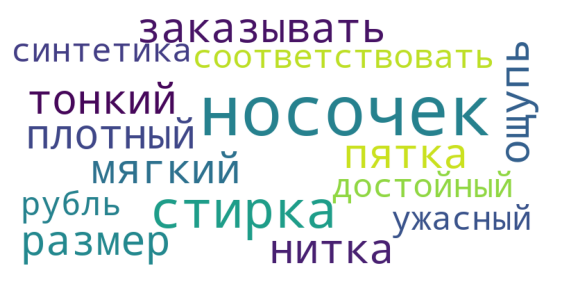

In [120]:
def plot_wordcloud(preprocessed_comments, mask=None, max_words=15, max_font_size=100, figure_size=(8.0,8.0), 
                   title = None, image_color=False):
    stopwords = {}
    wordcloud = WordCloud(background_color='white',
                    mask=None,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 666,
                    contour_width=1,
                    contour_color='black',
                    width=800, 
                    height=400,
                    )
    wordcloud.generate(str(preprocessed_comments))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        #plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  #'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
plot_wordcloud(preprocessed_comments)

# tf-idf

In [121]:
vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2))

In [122]:
vectorized_comments = vectorizer.fit_transform(preprocessed_comments)

In [123]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [228]:
def pos_define(x):
    m = Mystem()
    w = m.analyze(x)[0]
    pos = w['analysis'][0]['gr'].split(',')[0]
    pos = pos.split('=')[0].strip()
    return pos

tfidf['pos'] = tfidf.index.map(lambda x: pos_define(x))

# TFIDF1 result

In [245]:
#Эти слова показываем пользователю, он вводит то, по чему хочет почитать подробнее, или свое слово
tfidf[(tfidf['pos']!='V') & (tfidf['pos'] !='ADV')].sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf,pos
носочек,2.070441,S
стирка,2.475907,S
размер,2.475907,S
тонкий,2.609438,A
мягкий,2.763589,A


# Spacy. Looking for most similar comments for each word

In [125]:
nlp = spacy.load('ru_core_news_lg')

In [126]:
def top_10_similar(word_for_checking, dataframe):

    critical_similarity_value = 0.44
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    pos = []
    for i in range(len(dataframe['lemma_comment'])):
        similarities.append(nlp(dataframe['lemma_comment'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [160]:
#%time
#start_time = time.time()
top_10_similar('полагать', df)
#print("--- %s seconds ---" % (time.time() - start_time))

'По вашему запросу совпадений не найдено'

# Delete Stopwords. TFIDF once again

(array([ 1.,  0.,  2.,  1.,  0.,  2.,  2.,  9.,  0., 21.]),
 array([2.07044141, 2.20907085, 2.34770028, 2.48632972, 2.62495916,
        2.76358859, 2.90221803, 3.04084746, 3.1794769 , 3.31810634,
        3.45673577]),
 <BarContainer object of 10 artists>)

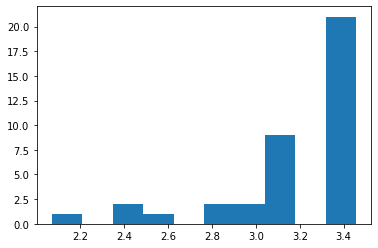

In [128]:
# df[~(df.gender == 'F') | (df.age > 40)]

plt.hist(tfidf.sort_values('tfidf'))


In [129]:
max_lim = 6
min_lim = 3

In [130]:
SW_tfidf = tfidf[(tfidf['tfidf']>max_lim)|(tfidf['tfidf']<min_lim)].reset_index()['index'].tolist()

In [131]:
russian_stopwords.extend(SW_tfidf)

In [132]:
%time
df['lemma_comment_2'] = df['lemma_comment'].map(lambda x: delete_stopwords(x))
df = df.drop(df[df['lemma_comment']==''].index)

CPU times: user 5 µs, sys: 10 µs, total: 15 µs
Wall time: 28.8 µs


In [133]:
df.head(5)

,comment,date_time,color,size,thumb_up,thumb_down,prod_eval,prod,brand,cleaned_comment,lemma_comment,lemma_comment_2
0,"Носочки соответствуют цене, похоже долго их но...",2021-02-09T10:02:50Z,светло-серый,24,2,0,3,Носки - 2 пары,Носи свое!,носочки соответствуют цене похоже носить придё...,носочек соответствовать похоже носить приходит...,соответствовать похоже носить приходиться симп...
1,"Вроде неплохо, тонковато немного. Но! Неужели ...",2021-02-08T15:02:01Z,светло-серый,20,1,0,4,Носки - 2 пары,Носи свое!,вроде неплохо тонковато неужели додуматься пар...,вроде неплохо тонковато неужели додумываться п...,вроде неплохо тонковато неужели додумываться п...
2,"Носочки хорошие, когда заказала второй раз вме...",2020-10-14T06:39:20Z,светло-серый,24,1,0,1,Носки - 2 пары,Носи свое!,носочки хорошие заказала вместо заказанного пр...,носочек заказывать вместо заказывать размер пу...,заказывать вместо заказывать пункт выдача обра...
3,"Носочки вполне достойные. Брали на ножку 14,5 ...",2020-09-01T12:09:16Z,светло-серый,16,1,0,5,Носки - 2 пары,Носи свое!,носочки вполне достойные брали ножку велики,носочек вполне достойный ножка великий,вполне достойный ножка великий
4,"Незнаю, что за такие новейшие технологии, но н...",2020-08-26T08:46:14Z,светло-серый,16,3,0,2,Носки - 2 пары,Носи свое!,незнаю новейшие технологии качественные ощуп с...,незнать технология качественный ощуп синтетика...,незнать технология качественный ощуп синтетика...


In [134]:
df = df.reset_index(drop = True)

In [135]:
preprocessed_comments_2 = df['lemma_comment_2']

In [136]:
vectorizer2 = TfidfVectorizer(min_df=2, ngram_range=(1, 2))
vectorized_comments_2 = vectorizer2.fit_transform(preprocessed_comments_2)

In [137]:
#  creating a dictionary mapping the tokens to their tfidf values
tfidf2 = dict(zip(vectorizer2.get_feature_names(), vectorizer2.idf_))
tfidf2 = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf2), orient='index')
tfidf2.columns = ['tfidf']

# TFIDF2 result

In [234]:
tfidf2['pos'] = tfidf2.index.map(lambda x: pos_define(x))

In [246]:
#Эти слова показываем пользователю, он вводит то, по чему хочет почитать подробнее, или свое слово
tfidf2[(tfidf2['pos']!='V') & (tfidf2['pos'] !='ADV')].sort_values(by=['tfidf'], ascending=True).head(5)

,tfidf,pos
ножка,3.169054,S
ощупь,3.169054,S
плотный,3.169054,A
пятка,3.169054,S
резинка,3.169054,S


# Spacy2. Looking for most similar comments for each word

In [141]:
nlp = spacy.load('ru_core_news_lg')

In [190]:
def top_10_similar2(word_for_checking, dataframe):
    critical_similarity_value = 0.2
    
    word_for_checking = nlp(word_for_checking)
    similarities = []
    for i in range(len(dataframe['lemma_comment_2'])):
        similarities.append(nlp(dataframe['lemma_comment_2'][i]).similarity(word_for_checking))
    
    df_temp = dataframe.copy()
    
    df_temp[f'similarity_to_{word_for_checking}'] = similarities
    
    #сортировка по убыванию similarities, фильтрация в соответствии с critical_similarity_value
    df_temp = df_temp.sort_values(by = f'similarity_to_{word_for_checking}', ascending = False).head(10)
    res = df_temp[df_temp[f'similarity_to_{word_for_checking}'] > critical_similarity_value][['comment', f'similarity_to_{word_for_checking}']]
    res = list(res['comment'])
    
    if len(res)>0:
        return res
    else: 
        return "По вашему запросу совпадений не найдено"

In [247]:
top_10_similar2('ножка', df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  import sys


['Носочек и пятка думаю быстро протрется.',
 'Отличные. Средней плотности, взяли для садика, не скатались после стирки, на ощупь очень мягкие приятные к ножке.',
 'Носочки вполне достойные. Брали на ножку 14,5 см. Не велики).',
 'Носки ужасного качества: после первой стирки образовались катышки,  пятки и носочки сделаны из более тонких нитей, чем сами носки.  В результате через пару месяцев появились дырки и носки стали похожи на лохматые валенки. Не советую. Да ещё, пришли другого цвета.',
 'Носки с первого взгляда понравились. Мягкие. Постирала руками. Не сели. Думала даже заказать ещё. Но! После машинной стирки на 40 градусах сели и очень сильно. Жалею, что не взяла на размер больше. Малы. На ножку 17 см. размер 18 после машинной стирки сделался маленьким. Увы. Берите с запасом!',
 'На первый взгляд очень даже достойные. Но через две носки у одной пары протёрлись пятки, вторые продержались подольше.']

# LDA

In [145]:
count_vect = CountVectorizer()
dataset_vectorized = count_vect.fit_transform(df['lemma_comment_2'])

In [146]:
lda = LDA(n_components = 15, max_iter=30, n_jobs=-1, learning_method='online', verbose=1, random_state=100, learning_decay = 0.65)
lda_output = lda.fit_transform(dataset_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [147]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(dataset_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(dataset_vectorized))

# See model parameters
print(lda.get_params())

Log Likelihood:  -1266.3386080274677
Perplexity:  599.232419567914
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.65, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 30, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 1}


## Grid search LDA

In [148]:
# Define Search Param
search_params = {'n_components': [5, 7, 9, 10], 'learning_decay': [.5, .6, .9]}

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(dataset_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_i

iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of ma

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of ma

iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of ma

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_it

GridSearchCV(estimator=LatentDirichletAllocation(learning_decay=0.65,
                                                 learning_method='online',
                                                 max_iter=30, n_components=15,
                                                 n_jobs=-1, random_state=100,
                                                 verbose=1),
             param_grid={'learning_decay': [0.5, 0.6, 0.9],
                         'n_components': [5, 7, 9, 10]})

In [149]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(dataset_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -464.83763886687575
Model Perplexity:  474.068143701294


In [150]:
res = pd.DataFrame(model.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_decay,param_n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.738515,0.070596,0.020905,0.008916,0.5,5,"{'learning_decay': 0.5, 'n_components': 5}",-682.884284,-578.670103,-344.770796,-427.217637,-413.558426,-489.420249,123.240833,3
1,0.538165,0.072205,0.023451,0.018733,0.5,7,"{'learning_decay': 0.5, 'n_components': 7}",-802.804498,-678.202479,-409.242656,-504.999299,-487.511798,-576.552146,143.222468,5
2,0.544719,0.070394,0.014101,0.003518,0.5,9,"{'learning_decay': 0.5, 'n_components': 9}",-915.204160,-794.585691,-471.390585,-575.659684,-556.536402,-662.675304,165.286540,8
3,2.913847,4.729141,0.012863,0.001806,0.5,10,"{'learning_decay': 0.5, 'n_components': 10}",-971.035891,-845.470517,-493.605674,-602.525110,-589.384035,-700.404245,178.301527,10
4,0.506719,0.017367,0.013867,0.003024,0.6,5,"{'learning_decay': 0.6, 'n_components': 5}",-676.576183,-573.844531,-342.377739,-423.614752,-409.368020,-485.156245,122.003374,2


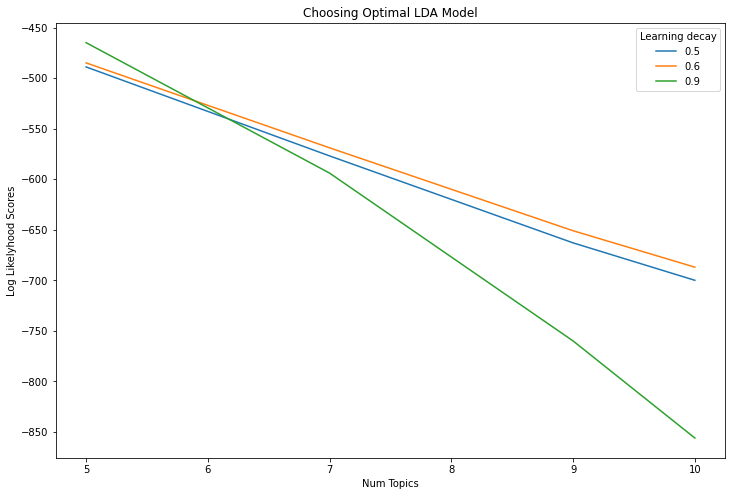

In [151]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 7, 9, 10]
log_likelyhoods_5 = res[res['param_learning_decay']==0.5][['mean_test_score']].round()
log_likelyhoods_6 = res[res['param_learning_decay']==0.6][['mean_test_score']].round()
log_likelyhoods_9 = res[res['param_learning_decay']==0.9][['mean_test_score']].round()

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_6, label='0.6')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


## Topics LDA

In [152]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(dataset_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.020000,0.910000,0.020000,0.020000,0.020000,1
Doc1,0.010000,0.960000,0.010000,0.010000,0.010000,1
Doc2,0.020000,0.020000,0.020000,0.020000,0.940000,4
Doc3,0.040000,0.840000,0.040000,0.040000,0.040000,1
Doc4,0.010000,0.950000,0.010000,0.010000,0.010000,1
Doc5,0.050000,0.800000,0.050000,0.050000,0.050000,1
Doc6,0.040000,0.040000,0.040000,0.840000,0.040000,3
Doc7,0.040000,0.040000,0.040000,0.040000,0.840000,4
Doc8,0.070000,0.070000,0.070000,0.730000,0.070000,3
Doc9,0.010000,0.010000,0.010000,0.010000,0.940000,4


In [153]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,11
1,4,7
2,2,6
3,3,6
4,0,4


In [154]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, dataset_vectorized, count_vect, mds='tsne')
panel

/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1      150.222153  -72.269554       1        1  31.578227
4       51.163364 -159.968018       2        1  24.986384
2      -73.144554   21.523815       3        1  22.348296
3      -66.410133 -110.606438       4        1  12.493596
0       54.417324   12.443444       5        1   8.593497, topic_info=            Term      Freq     Total Category  logprob  loglift
98      приятный  1.000000  1.000000  Default  30.0000  30.0000
102  протираться  1.000000  1.000000  Default  29.0000  29.0000
75         ощупь  1.000000  1.000000  Default  28.0000  28.0000
105        пятка  1.000000  1.000000  Default  27.0000  27.0000
108      резинка  1.000000  1.000000  Default  26.0000  26.0000
..           ...       ...       ...      ...      ...      ...
12        вполне  0.094542  1.257322   Topic5  -5.1928  -0.1335
153          шов  0.094012  1.241717   Topic5  -5.1984  -0.1267
13         вроде  0.094118  1.249126   Topic5  -5.1973  -0.1315
24        грубый  0.093034  1.236924   Topic5  -5.2089  -0.1333
20       высокий  0.092653  1.215788   Topic5  -5.2130  -0.1201

[232 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         1  0.599301    аккуратно
0         2  0.599301    аккуратно
1         1  0.820325   аккуратный
2         1  0.819362         ашан
3         3  0.864642    болтаться
...     ...       ...          ...
151       3  0.883476         цвет
153       1  0.805337          шов
154       1  0.794090    щиколотка
155       1  0.815322   эластичный
156       1  0.816573  элементарно

[141 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 4, 1])

In [155]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = count_vect.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,аккуратно,аккуратный,ашан,болтаться,большемерить,валенок,великий,весна,вместо,внимание,...,ужасный,упаковка,упаковывать,хорошенький,цвет,целое,шов,щиколотка,эластичный,элементарно
Topic0,0.295306,0.325703,0.335573,0.327873,0.317438,0.323779,0.313401,0.326744,0.330263,0.318364,...,0.293636,0.339969,0.313490,0.316624,0.313944,0.320402,0.343894,0.336122,0.337199,0.315658
Topic1,1.176419,1.199722,1.179310,0.317319,1.175438,0.344574,1.152103,0.322713,0.307122,0.293375,...,1.171083,0.320177,0.332734,0.313229,0.282224,0.297161,1.181307,1.182492,1.180812,1.187554
Topic2,0.303244,0.280973,0.312393,1.173792,0.343156,1.152794,0.337593,0.318726,0.309704,0.306514,...,1.182565,1.183175,1.189133,0.307891,1.160468,0.333352,0.317631,0.341000,0.314976,0.314012
Topic3,0.308894,0.333526,0.320446,0.322307,0.320314,0.326826,0.314165,1.178968,0.325475,0.324834,...,0.323591,0.346429,0.330691,1.180249,0.332996,1.160793,0.311501,0.328318,0.340544,0.320738
Topic4,1.193714,0.310912,0.309827,0.325914,0.316800,0.339731,0.347007,0.329367,1.199445,1.182986,...,0.314663,0.313511,1.202929,0.320736,0.331162,0.323159,0.344260,0.346686,0.302982,0.317061


## из ф-ции ниже надо убрать глаголы, пока не придумала

In [260]:
# Show top n keywords for each topic
def show_topics(vectorizer=count_vect, lda_model=lda, n_words=15):
    keywords = np.array(count_vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,полагать,описание,резинка,обычный,отказ,торчать,запас,примерно,ночка,получаться,прошивать,соответственно,строчка,тянуться,скататься
Topic 1,рисунок,соответствовать,торчать,симпатичный,вполне,незнать,единственно,аккуратный,вроде,отк,высокий,ощуп,вырастать,элементарно,пошив
Topic 2,резинка,потерять,дырочка,тянуться,заявлять,советовать,дырка,упаковывать,ровный,оказываться,принт,упаковка,стоить,ужасный,нить
Topic 3,ощупь,приятный,пятка,протираться,поэтому,садиться,ножка,хорошенький,весна,заказывать,рекомедовать,сильно,средний,достойный,целое
Topic 4,заказывать,машинный,вязка,садиться,рубль,упаковывать,плохой,вместо,плотный,аккуратно,неприятный,рекомендовать,сожаление,технологический,обращать


In [263]:
    keywords = np.array(count_vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lda.components_:
        top_keyword_locs = (-topic_weights).argsort()[:15]
        topic_keywords.append(keywords.take(top_keyword_locs))
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    #df_topic_keywords

In [ ]:
def pos_define(x):
    m = Mystem()
    w = m.analyze(x)[0]
    pos = w['analysis'][0]['gr'].split(',')[0]
    pos = pos.split('=')[0].strip()
    return pos

tfidf['pos'] = tfidf.index.map(lambda x: pos_define(x))